## Событийная аналитика A/B-эксперимента

В нашем приложении пользователей разбили на 2 группы: контрольная группа со старой рекомендательной системой и одна экспериментальная — с новой. Необходимо выяснить, какая рекомендательная система лучше.


## Цель проекта.

Изучить воронку продаж и оценить корректность проведения теста, а также исследовать результаты A/B-эксперимента по внедрению рекомендательной системы. 


## Задачи проекта.

Во время исследования необходимо решить следующие задачи:

1. Изучить исходные данные и провести их предобработку.
2. Оценить корректность проведения теста.
3. Провести исследовательский анализ данных (EDA).
4. Оценить эффективность проведенного A/B-эксперимента.


## Техническое задание.

Название теста: recommender_system_test;  
группы: А — контрольная, B — новая платёжная воронка;  
дата запуска: 2020-12-07;  
дата остановки набора новых пользователей: 2020-12-21;  
дата остановки: 2021-01-04;  
аудитория: 15% новых пользователей из региона EU;  
назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;  
ожидаемое количество участников теста: 6000.  
ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:  
• конверсии в просмотр карточек товаров — событие product_page,  
• просмотры корзины — product_cart,  
• покупки — purchase.  


## Описание данных.  

<div style="border:solid black 1px; padding: 20px">   

Имеются датафреймы со следующими данными:

*ab_project_marketing_events.csv* — календарь маркетинговых событий на 2020 год.

Структура файла:  
    
•	`name` — название маркетингового события;  
•	`regions` — регионы, в которых будет проводиться рекламная кампания;  
•	`start_dt` — дата начала кампании;  
•	`finish_dt` — дата завершения кампании.  

*final_ab_new_users.csv* — пользователи, зарегистрировавшиеся с 7 по 21 декабря
2020 года.
    
Структура файла: 
    
•	`user_id` — идентификатор пользователя;  
•	`first_date` — дата регистрации;  
•	`region` — регион пользователя;  
•	`device` — устройство, с которого происходила регистрация.  

*final_ab_events.csv* — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.
    
Структура файла:  
    
•	`user_id` — идентификатор пользователя;  
•	`event_dt` — дата и время покупки;  
•	`event_name` — тип события;  
•	`details` — дополнительные данные о событии. Например, для покупок,  
•	`purchase`— в этом поле хранится стоимость покупки в долларах.

*final_ab_participants.csv* — таблица участников тестов.
    
Структура файла:  
    
•	`user_id` — идентификатор пользователя;  
•	`ab_test` — название теста;  
•	`group` — группа пользователя.  

# Импортируем библиотеки и изучим данные.

In [1]:
import pandas as pd
pd.set_option("display.precision", 2)
pd.options.mode.chained_assignment = None  # default='warn'
import plotly.express as px
from plotly import graph_objects as go
import plotly.io as pio
png_renderer = pio.renderers["svg"]
png_renderer.width = 950
png_renderer.height = 600
pio.renderers.default = "svg"
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
path = 'C:\\Users\\Sergey\\Documents\\Python Scripts\\Диплом\\AB-тест\\'
try:
    calendar, users, actions, members = (
    pd.read_csv(path + 'final_ab_marketing_events.csv'), # календарь событий 
    pd.read_csv(path + 'final_ab_new_users.csv'),          # пользователи
    pd.read_csv(path + 'final_ab_events.csv'),             # действия пользователей
    pd.read_csv(path + 'final_ab_participants.csv')        # участники теста
    )
except:
    print('Loading Error')

In [3]:
NORM = '\033[0m'  # все атрибуты по умолчанию
BOLD = '\033[1m'  # жирный шрифт (интенсивный цвет)
df_list = [calendar, users, actions, members]

#Напишем функцию для вывода основной информации о ДФ.
def full_info(df_list):
    for df in df_list:
        if len(df.index) > 10:
            print(BOLD+'\n Случайная выборка 10 строк датафрейма:')
            display (df.sample(n=10, random_state=10))
        else:
            print(BOLD+'\n Первые 10 строк датафрейма:')
            display (df.head(10))
        print(BOLD+'\n Типы данных и общая информация: \n'+NORM)
        display(df.info())
        print(BOLD+' Наличие дубликатов: '+NORM, df.duplicated().sum())
        print(BOLD+'\n Наличие пропусков: \n'+NORM)
        display(df.isna().sum())
        print(BOLD+'\n Статистики количественных переменных :')
        display(df.describe())
        print('*'*50)
    return

In [4]:
full_info(df_list)


 Случайная выборка 10 строк датафрейма:


,name,regions,start_dt,finish_dt
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
12,Single's Day Gift Promo,APAC,2020-11-11,2020-11-12
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

 Наличие дубликатов:  0

 Наличие пропусков: 



name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


 Статистики количественных переменных :


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


**************************************************

 Случайная выборка 10 строк датафрейма:


,user_id,first_date,region,device
13739,8385EBA5F20CA915,2020-12-21,APAC,Mac
24008,30EF274147DFDE46,2020-12-22,EU,iPhone
60364,18F0ED3A92505168,2020-12-20,CIS,PC
40982,40A06E4DB1C23AB4,2020-12-11,CIS,Mac
6237,791D7C47A66650F2,2020-12-14,APAC,PC
8319,DF0131F98856817C,2020-12-14,EU,Android
32914,58B6DD816A387B42,2020-12-23,N.America,Mac
49640,41CC36D51D192DC8,2020-12-19,EU,PC
35685,0F7B4F098201E2E7,2020-12-10,EU,Android
56821,B8013B27063F6A8B,2020-12-13,EU,Android



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

 Наличие дубликатов:  0

 Наличие пропусков: 



user_id       0
first_date    0
region        0
device        0
dtype: int64


 Статистики количественных переменных :


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


**************************************************

 Случайная выборка 10 строк датафрейма:


,user_id,event_dt,event_name,details
58979,7F6B8AFA28452E10,2020-12-27 16:13:20,purchase,4.99
267124,DC851421924CC7AD,2020-12-10 06:05:51,login,NaN
407904,7FE00741802E64B8,2020-12-24 05:35:51,login,NaN
30159,BA8EACB5B7E61076,2020-12-18 18:43:25,purchase,99.99
410922,D7CFD6BCF119F5FF,2020-12-24 22:17:13,login,NaN
393133,E9114BF50373408E,2020-12-23 02:10:33,login,NaN
323463,F1A6F16D2C002E7B,2020-12-16 23:40:52,login,NaN
92351,1D527289BDFB7B46,2020-12-18 09:38:55,product_cart,NaN
233736,F7BF6A91291DCD41,2020-12-25 07:31:50,product_page,NaN
84159,DA6D8FD11077466A,2020-12-15 19:07:02,product_cart,NaN



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

 Наличие дубликатов:  0

 Наличие пропусков: 



user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64


 Статистики количественных переменных :


,details
count,62740.00
mean,23.88
std,72.18
min,4.99
25%,4.99
50%,4.99
75%,9.99
max,499.99


**************************************************

 Случайная выборка 10 строк датафрейма:


,user_id,group,ab_test
4714,982ECA66C1761BC6,A,recommender_system_test
16889,F645C46B8CE342C2,B,interface_eu_test
2962,FDC4F5414D325E59,A,recommender_system_test
14748,46A7B6A9C1C4E46B,A,interface_eu_test
17649,E0E4E8A28919B292,A,interface_eu_test
5274,1B977F772D622D53,A,recommender_system_test
14814,7E0D60AF41DECEC6,A,interface_eu_test
8277,432A7E6C10FE6B18,B,interface_eu_test
4715,D17646F57096613B,A,recommender_system_test
10724,739656E0D7B50B30,A,interface_eu_test



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

 Наличие дубликатов:  0

 Наличие пропусков: 



user_id    0
group      0
ab_test    0
dtype: int64


 Статистики количественных переменных :


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


**************************************************


Можно увидеть, что все ДФ находятся в идеальном состоянии - без дубликатов, пропусков и аномальных значений, с соответствующими типами данных. Для корректной работы требуется только привести все столбцы с датами к необходимому типу.

In [5]:
calendar['start_dt'] = pd.to_datetime(calendar['start_dt'])
calendar['finish_dt'] = pd.to_datetime(calendar['finish_dt'])
users['first_date'] = pd.to_datetime(users['first_date'])
actions['event_dt'] = pd.to_datetime(actions['event_dt'])

## Вывод

<div style="border:solid green 2px; padding: 20px">
Данные изучены и готовы для дальнейшего исследования, т.к. ДФ в идеальном состоянии - дубликаты, аномальные значения не наблюдаются, типы данных верные. Для удобства только заменены типы данных дат на соответствующие. Пропуски есть только в ДФ с событиями в комментариях, но их природа объясняется наличием суммы покупки только на соответствующем этапе.

# Оценка корректности проведения теста.

## Соответствие данных требованиям технического задания.

Для первоначального анализа проверим соответствие данных требованиям ТЗ, а именно:

- Дата запуска: 2020-12-07;  
- Дата остановки набора новых пользователей: 2020-12-21;  
- Дата остановки: 2021-01-04;  
- Аудитория: 15% новых пользователей из региона EU;  
- Ожидаемое количество участников теста: 6000.
Для ответа на эти вопросы нам необходимо сначала объединить две таблицы - с регистрацией новых пользователей и с участниками A/B-теста.

In [6]:
users2 = users.merge(members, how='left', on='user_id')
users2

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,F1C668619DFE6E65,2020-12-07,N.America,Android,NaN,NaN
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
3,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,NaN,NaN
...,...,...,...,...,...,...
63330,1DB53B933257165D,2020-12-20,EU,Android,NaN,NaN
63331,538643EB4527ED03,2020-12-20,EU,Mac,NaN,NaN
63332,7ADEE837D5D8CBBD,2020-12-20,EU,PC,NaN,NaN
63333,1C7D23927835213F,2020-12-20,EU,iPhone,B,interface_eu_test


In [7]:
print('Новые пользователи привлечены в период с {} по {}.'.format(
    users2.query('group == ["A", "B"] and ab_test == "recommender_system_test"').first_date.min().date(),
    users2.query('group == ["A", "B"] and ab_test == "recommender_system_test"').first_date.max().date()))
print('Действия совершались в период с {} по {}.'.format(
    actions.event_dt.min().date(), actions.event_dt.max().date()))
print('Аудитория A/B-теста составляет {} %.'.format(round(
    users2.query('group == ["A", "B"] and ab_test == "recommender_system_test"').region.value_counts()[0] /
    users2.region.value_counts()[0] * 100, 2)))
print('Фактическое количество участников составляет {} пользователей.'.format(
    members.ab_test.value_counts()[1]))

Новые пользователи привлечены в период с 2020-12-07 по 2020-12-21.
Действия совершались в период с 2020-12-07 по 2020-12-30.
Аудитория A/B-теста составляет 13.27 %.
Фактическое количество участников составляет 6701 пользователей.


Таким образом, у нас соблюдаются установленные ТЗ сроки набора пользователей в тест, но нарушаются срок проведения теста (заканчивается 2020-12-30 вместо 2021-01-04) и процесс набора юзеров (13,3% новых пользователей из региона EU вместо 15% и 6701 вместо 6000 всего).   

## Проверка отсутствия маркетинговых событий во время проведения теста.

In [8]:
calendar.sort_values(by='start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


Можем заметить, что у нас имеется два пересечения с тестом. При этом, событие новогодней лотереи проводилось только в странах СНГ, а значит к нашему тесту отношения не имеет. Но влияние могло оказать событие "Рождество и НГ промо", проводимое и в Европе, в том числе. Результаты теста из-за этого, возможно, могут оказаться недостаточно достоверными.

## Оценка корректности набора аудитории теста. 

Помимо некорректного набора аудитории в количественном выражении необходимо еще оценить в качественном, удостоверившись, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно, а также проверив равномерность распределения пользователей по тестовым группам и правильность их формирования.

In [9]:
print('Количество пользователей, находящихся в обоих тестах, составляет {}.'
      .format(len(list(set(members.query('ab_test=="recommender_system_test"').user_id) & 
                       set(members.query('ab_test=="interface_eu_test"').user_id)))))
print('Количество пользователей, находящихся в обоих группах теста, составляет {}.'
      .format(len(list(set(members.query('ab_test=="recommender_system_test" and group=="A"').user_id) & 
                       set(members.query('ab_test=="recommender_system_test" and group=="B"').user_id)))))
print('Количество пользователей, находящихся группе A и B нашего теста, составляет {} и {} соответственно.'
      .format(members.query('ab_test=="recommender_system_test"').group.value_counts()[0],
              members.query('ab_test=="recommender_system_test"').group.value_counts()[1]))

Количество пользователей, находящихся в обоих тестах, составляет 1602.
Количество пользователей, находящихся в обоих группах теста, составляет 0.
Количество пользователей, находящихся группе A и B нашего теста, составляет 3824 и 2877 соответственно.


Таким образом, в рамках нашего теста у нас нет пересечений по группам, но разделение по группам выполнено в соотношении 57:43, а также имеется пересечение пользователей между двумя тестами, в том числе в двух экспериментальных группах и в контрольной нашего теста и экспериментальной второго теста, что тоже может вести к недостоверным результатам.

Т.к. нам достоверно неизвестно, в какой пропорции предусматривалось разбиение на группы в нашем тесте, то избавимся только от пользователей, которые находились в эксперементальных группах обоих тестов, в контрольной нашего теста и экспериментальной второго теста, в группах второго теста, а так же в других регионах. Удалять тех, кто не "прожил" полноценные две недели в соответствии с ТЗ пока не будем, т.к., возможно, активность пользователей в последние несколько дней все равно незначительна.

In [10]:
a_test1_b_test2 = list(set(members.query('ab_test == "recommender_system_test" and group == "A"').user_id) & 
                     set(members.query('ab_test == "interface_eu_test" and group == "B"').user_id))

In [11]:
b_group_users = list(set(members.query('ab_test == "recommender_system_test" and group == "B"').user_id) & 
                     set(members.query('ab_test == "interface_eu_test" and group == "B"').user_id))

In [12]:
members_clean = members.query('user_id != @b_group_users and user_id != @a_test1_b_test2 and ab_test !="interface_eu_test"')
members_clean

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test
6697,9D263B8EF15CF188,B,recommender_system_test
6698,F2FBBA33F37DEC46,A,recommender_system_test
6699,29C92313A98B1176,B,recommender_system_test


In [13]:
users_clean = users.merge(members_clean, on='user_id')
users_clean = users_clean.query('region == "EU"')
users_clean

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
2,831887FE7F2D6CBA,2020-12-07,EU,Android,A,recommender_system_test
3,4CB179C7F847320B,2020-12-07,EU,iPhone,B,recommender_system_test
6,16C69ED14DA9F4A8,2020-12-07,EU,PC,B,recommender_system_test
...,...,...,...,...,...,...
5913,3CA972F86411CF13,2020-12-20,EU,PC,A,recommender_system_test
5914,0F7D49FC184EDCDE,2020-12-20,EU,PC,A,recommender_system_test
5915,574ACBC674BC385D,2020-12-20,EU,Mac,A,recommender_system_test
5916,0416B34D35C8C8B8,2020-12-20,EU,Android,A,recommender_system_test


После всех фильтраций пользователей у нас получилось почти предполагаемое количество пользователей - 5568 вместо 6000. Можем переходить к анализу событий и конверсии.

## Вывод

<div style="border:solid green 2px; padding: 20px">
После предварительного анализа и обработки данных можно сделать следующие выводы:
    
- у нас **соблюдаются установленные ТЗ сроки набора пользователей в тест, но нарушаются срок проведения теста** (заканчивается 2020-12-30 вместо 2021-01-04) **и процесс набора юзеров** (13,3% новых пользователей из региона EU вместо 15% и 6701 вместо 6000 всего)
- у нас **имеется два пересечения маркетинговых событий с тестом**. При этом, событие новогодней лотереи проводилось только в странах СНГ, а значит к нашему тесту отношения не имеет. Но **влияние могло оказать событие "Рождество и НГ промо"**, проводимое и в Европе, в том числе
- у нас **нет пересечений по группам, но разделение по группам выполнено в соотношении 57:43, а также имеется пересечение пользователей между двумя тестами, в том числе в двух экспериментальных группах и в контрольной нашего теста и экспериментальной второго теста**
- **после всех фильтраций пользователей** у нас получилось почти предполагаемое **количество пользователей - 5568 вместо 6000**
    
**Данные нарушения чистоты эксперимента могут дать впоследствии недостаточно достоверные результаты.**

# Исследовательский анализ данных (EDA).

## Количество событий на пользователя.

Для проведения исследовательского анализа нам необходимо объединить две таблицы - юзеров с событиями, после чего отфильтруем наш ДФ с действиями, т.к. нас интересует активность каждого пользователя только в рамках двух недель, без дальнейших его действий.

In [14]:
#Объединяем ДФ и убираем действия после 14 дней, чтобы не убрать юзеров без действий.
actions_clean = actions.merge(users_clean, how='right', on='user_id')
actions_clean['diff_time'] = actions_clean['event_dt'] - actions_clean['first_date']
actions_clean['diff_days'] = actions_clean['diff_time'].dt.days
old_actions = actions_clean[actions_clean.diff_days > 14].index.to_list()
actions_clean = actions_clean.query('index != @old_actions')
actions_clean

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test,diff_time,diff_days
0,D72A72121175D8BE,2020-12-07 21:52:10,product_page,NaN,2020-12-07,EU,PC,A,recommender_system_test,0 days 21:52:10,0.0
1,D72A72121175D8BE,2020-12-07 21:52:07,login,NaN,2020-12-07,EU,PC,A,recommender_system_test,0 days 21:52:07,0.0
2,DD4352CDCF8C3D57,2020-12-07 15:32:54,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test,0 days 15:32:54,0.0
3,DD4352CDCF8C3D57,2020-12-08 08:29:31,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test,1 days 08:29:31,1.0
4,DD4352CDCF8C3D57,2020-12-10 18:18:27,product_page,NaN,2020-12-07,EU,Android,B,recommender_system_test,3 days 18:18:27,3.0
...,...,...,...,...,...,...,...,...,...,...,...
23077,0416B34D35C8C8B8,2020-12-24 09:12:51,product_page,NaN,2020-12-20,EU,Android,A,recommender_system_test,4 days 09:12:51,4.0
23078,0416B34D35C8C8B8,2020-12-20 20:58:25,login,NaN,2020-12-20,EU,Android,A,recommender_system_test,0 days 20:58:25,0.0
23079,0416B34D35C8C8B8,2020-12-21 22:28:29,login,NaN,2020-12-20,EU,Android,A,recommender_system_test,1 days 22:28:29,1.0
23080,0416B34D35C8C8B8,2020-12-24 09:12:49,login,NaN,2020-12-20,EU,Android,A,recommender_system_test,4 days 09:12:49,4.0


In [15]:
groups = (actions_clean.pivot_table(index='group', aggfunc={'event_dt': 'count', 'user_id': 'nunique'})
                       .rename(columns = {'event_dt': 'actions', 'user_id': 'users'}))
groups['actions_per_user'] = groups['actions'] / groups['users']
groups.loc['ratio'] = groups.loc['A'] / groups.loc['B']
groups

,actions,users,actions_per_user
group,,,
A,15851.00,3195.00,4.96
B,4183.00,2373.00,1.76
ratio,3.79,1.35,2.81


Можем видеть, что распределения в группах крайне неравномерные, а именно в контрольной группе А больше, чем в тестовой группе B:
- действий в 3.8 раз (15851 против 4183)
- пользователей в 1.4 раза (3195 против 2373)
- действий на пользователя в 2.8 раз (4.96 против 1.76)

Эти данные нам уже показывают о некорректно проведенном A/B-тесте, а также о потенциально неудовлетворительном эффекте нововведения. Продолжим анализ.

## Распределение событий по дням.

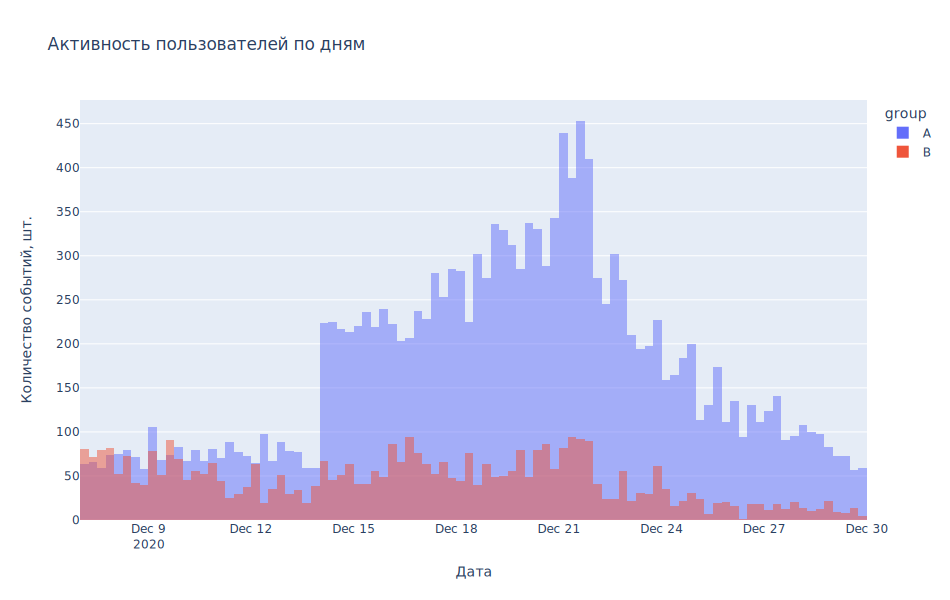

In [16]:
fig = px.histogram(actions_clean, x='event_dt', color='group', barmode='overlay', title='Активность пользователей по дням')
fig.update_layout(xaxis_title='Дата', yaxis_title='Количество событий, шт.')
fig.show()

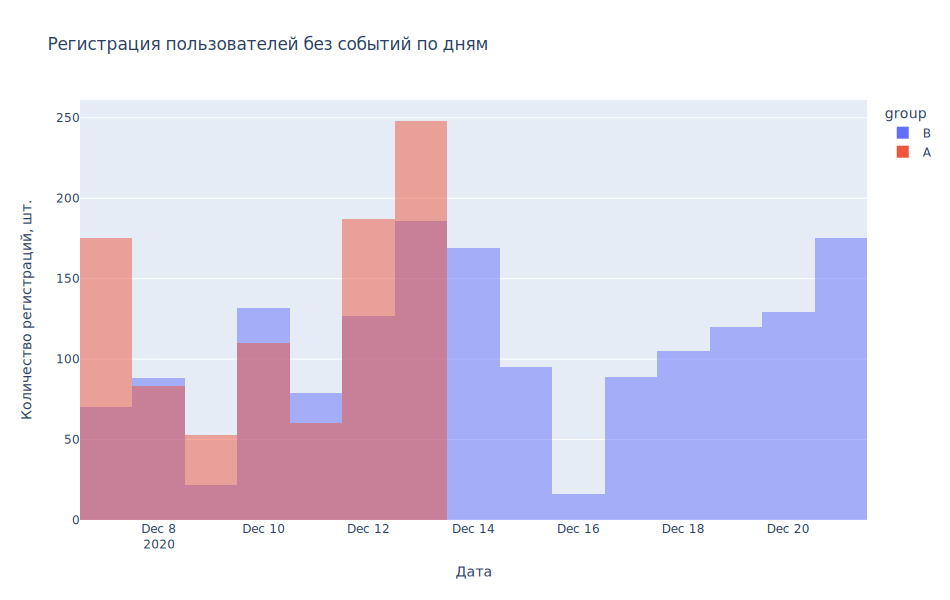

In [17]:
#Попробуем проанализировать аномальный скачок 14 декабря в контрольной группе.
unactive_users = actions_clean.pivot_table(index='user_id',
                                           aggfunc={'event_dt': 'count'}).reset_index()
unactive_users_id = unactive_users.query('event_dt == 0').user_id.to_list()
fig = px.histogram(actions_clean.query('user_id == @unactive_users_id'),
                   x='first_date', color='group', barmode='overlay',
                   title='Регистрация пользователей без событий по дням')
fig.update_layout(xaxis_title='Дата', yaxis_title='Количество регистраций, шт.')
fig.show()

По этой гистограмме можем увидеть, что 14 декабря в группе А произошел аномальный скачок, когда количество действий выросло в 3,8 раз, а затем было планомерное увеличение действий по мере набора аудитории теста. После дополнительного анализа причины стало очевидно, что этот скачок связан с тем, что до 14 декабря зарегистрированные пользователи не могли залогиниться, пока этот баг не исправили. Затем, с 22 декабря началось планомерное снижение действий в обоих группах, связанное, по всей видимости, с тем, что был закончен набор новых пользователей и продолжался уход старых. В тестовой группе В распределение более равномерное, но с кратно меньшей активностью пользоваетелей.  
Посмотрим на конверсию в воронке событий.

## Конверсия в воронке событий.

In [18]:
group_actions = (actions_clean.pivot_table(
                                           index='event_name', 
                                           columns='group', 
                                           values='user_id',
                                           aggfunc='nunique')
                              .reindex(['login', 'product_page',
                                        'product_cart', 'purchase'])
                              .reset_index())
group_actions

group,event_name,A,B
0,login,2279,770
1,product_page,1476,429
2,product_cart,686,214
3,purchase,734,219


In [19]:
#Посчитаем общее количество пользователей в каждой группе.
amount_users = (actions_clean.pivot_table(
                                          columns='group', 
                                          values='user_id',
                                          aggfunc='nunique'))
amount_users

group,A,B
user_id,3195,2373


In [20]:
#Объединим наши ДФ.
final_df = (pd.concat([amount_users, group_actions], axis=0).set_index('event_name')
              .set_axis(['Всего пользователей', 'Залогинились',
                      'Открыли каталог', 'Начали оформлять заказ',
                      'Оплатили товар'], axis=0))
final_df

group,A,B
Всего пользователей,3195,2373
Залогинились,2279,770
Открыли каталог,1476,429
Начали оформлять заказ,686,214
Оплатили товар,734,219


Посмотрим на разницу конверсии на каждом этапе между контрольными группами, построив воронку событий.

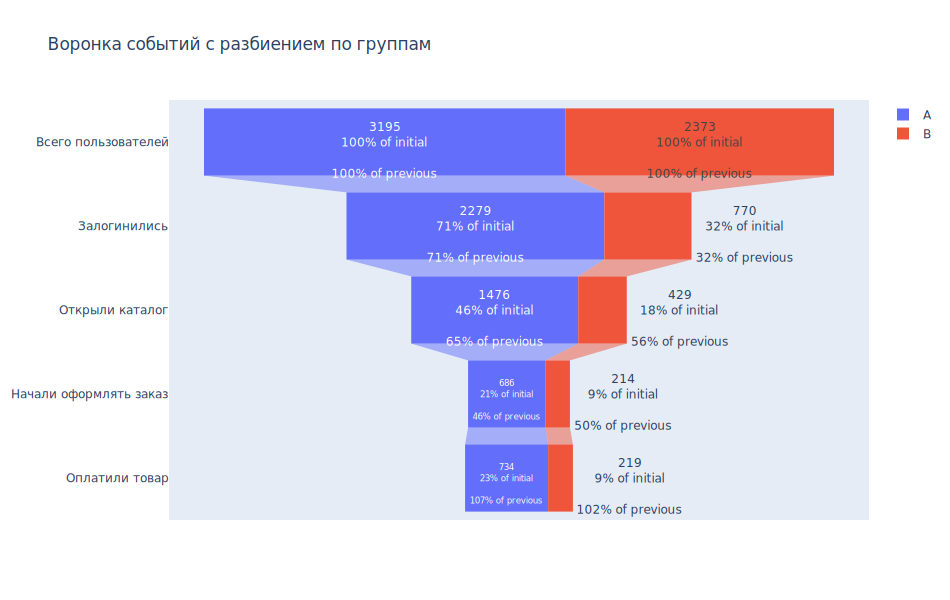

In [21]:
fig = go.Figure()

for i in ('A', 'B'):
    fig.add_trace(go.Funnel(
        name = i,
        y=final_df.index.tolist(),
        x=final_df[i].tolist(),
        textinfo = 'value+percent previous+percent initial'
    )
)
fig.update_layout(title='Воронка событий с разбиением по группам')
fig.show() 

Видно, что в группе B конверсия значительно хуже (9% против 23% в контрольной группе). Основной провал происходит еще на этапе ввода логина (конверсия всего 32% против 71% в контрольной группе), на что теоретически не должен был влиять наш тест. Также можно заметить, что событий с оплатой больше чем с оформлением, что говорит нам о том, что не все шаги к покупке обязательны для посещения.

## Вывод.

<div style="border:solid green 2px; padding: 20px">
Проведя исследовательский анализ данных, можно сделать следующие выводы:
    
Распределения в группах крайне неравномерные, а именно **в контрольной группе А больше, чем в тестовой группе B:**
- **действий в 3.8 раза** (15851 против 4183)
- **пользователей в 1.4 раз** (3195 против 2373)
- **действий на пользователя в 2.8 раз** (4.96 против 1.76)
  
По этой гистограмме можем увидеть, что **14 декабря в группе А произошел аномальный скачок**, когда количество действий выросло в 3,8 раз, а затем было планомерное увеличение действий по мере набора аудитории теста. После дополнительного анализа причины стало очевидно, что этот скачок связан с тем, что до 14 декабря зарегистрированные пользователи не могли залогиниться, пока этот баг не исправили. Затем, **с 22 декабря началось планомерное снижение действий в обоих группах**, связанное, по всей видимости, с тем, что был закончен набор новых пользователей и продолжался уход старых. **В тестовой группе В распределение более равномерное, но с кратно меньшей активностью пользоваетелей.** 
    
По воронке событий определили, что **в группе B конверсия значительно хуже (9% против 23% в контрольной группе). Основной провал происходит еще на этапе ввода логина (конверсия всего 32% против 71% в контрольной группе)**, на что теоретически не должен был влиять наш тест. Также можно заметить, что событий с оплатой больше чем с оформлением, что говорит нам о том, что не все шаги к покупке обязательны для посещения.
Все это в очередной раз указывает на то, что **A/B-тест проведен некорректно и с учетом этого с отрицательным эффектом от нововведения.**

# Оценка результатов A/B-тестирования.

Проверим, имеется ли у нас статистически значимая разница между группами. Для этого сформулируем нулевую и альтернативную гипотезу.

**Нулевая H0:** доли оплативших товар пользователей в контрольной группе А и в тестовой группе B равны  
**Альтернативная H1:** доли оплативших товар пользователей в контрольной группе А и в тестовой группе B не равны

In [22]:
#Напишем функцию для расчета статистической разницы между группами.
def difference(column_group1, column_group2, row, alpha):
    """
    Функция для проверки статистической гипотезы о равенстве долей
    
    column_group1 - выбор первого города
    column_group2 - выбор второго города
    row - выбор этапа события
    alpha - заданный критический уровень статистической значимости
    """ 
    events = final_df.index.tolist()
    
    alpha = alpha # критический уровень статистической значимости

    successes = np.array([final_df.iat[row, column_group1], final_df.iat[row, column_group2]])
    trials = np.array([final_df.iat[0, column_group1], final_df.iat[0, column_group2]])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print(f'Отвергаем нулевую гипотезу: на этапе "{events[row]}" между долями есть значимая разница')
    else:
        print(
            f'Не получилось отвергнуть нулевую гипотезу, на этапе "{events[row]}" нет оснований считать доли разными'
        ) 

In [23]:
#Используем цикл для проверки разницы на каждом этапе между контрольными группами.
for i in range(1, 5):
    difference (0, 1, i, .05)

p-значение:  0.0
Отвергаем нулевую гипотезу: на этапе "Залогинились" между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: на этапе "Открыли каталог" между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: на этапе "Начали оформлять заказ" между долями есть значимая разница
p-значение:  0.0
Отвергаем нулевую гипотезу: на этапе "Оплатили товар" между долями есть значимая разница


## Вывод.

<div style="border:solid green 2px; padding: 20px">
Проведя статистическую проверку z-критерием подтвердились предыдущие описанные нами выводы - **на всех этапах воронки между долями контрольной и тестовой группы есть значимая разница, A/B-тест проведен некорректно и с учетом этого имеется отрицательный эффект от нововведения.**

# Выводы.

<div style="border:solid green 2px; padding: 20px">
Проведя исследование и анализ поведения пользователей нашего мобильного приложения, можно сделать следующие выводы:

- ДФ в идеальном состоянии - дубликаты, аномальные значения не наблюдаются, типы данных верные. Для удобства только заменены типы данных дат на соответствующие. Пропуски есть только в ДФ с событиями в комментариях, но их природа объясняется наличием суммы покупки только на соответствующем этапе.
    
- у нас **соблюдаются установленные ТЗ сроки набора пользователей в тест, но нарушаются срок проведения теста** (заканчивается 2020-12-30 вместо 2021-01-04) **и процесс набора юзеров** (13,3% новых пользователей из региона EU вместо 15% и 6701 вместо 6000 всего)
- у нас **имеется два пересечения маркетинговых событий с тестом**. При этом, событие новогодней лотереи проводилось только в странах СНГ, а значит к нашему тесту отношения не имеет. Но **влияние могло оказать событие "Рождество и НГ промо"**, проводимое и в Европе, в том числе
- у нас **нет пересечений по группам, но разделение по группам выполнено в соотношении 57:43, а также имеется пересечение пользователей между двумя тестами, в том числе в двух экспериментальных группах и в контрольной нашего теста и экспериментальной второго теста**
- **после всех фильтраций пользователей** у нас получилось почти предполагаемое **количество пользователей - 5568 вместо 6000**
    
**Данные нарушения чистоты эксперимента могут дать впоследствии недостаточно достоверные результаты.**
    
 Распределения в группах крайне неравномерные, а именно **в контрольной группе А больше, чем в тестовой группе B:**
- **действий в 3.8 раза** (15851 против 4183)
- **пользователей в 1.4 раз** (3195 против 2373)
- **действий на пользователя в 2.8 раз** (4.96 против 1.76)

- по распределению событий по дням определили, что **14 декабря в группе А произошел аномальный скачок**, когда количество действий выросло в 3,8 раз, а затем было планомерное увеличение действий по мере набора аудитории теста. После дополнительного анализа причины стало очевидно, что этот скачок связан с тем, что до 14 декабря зарегистрированные пользователи не могли залогиниться, пока этот баг не исправили. Затем, **с 22 декабря началось планомерное снижение действий в обоих группах**, связанное, по всей видимости, с тем, что был закончен набор новых пользователей и продолжался уход старых. **В тестовой группе В распределение более равномерное, но с кратно меньшей активностью пользователей.** 
- по воронке событий определили, что **в группе B конверсия значительно хуже (9% против 23% в контрольной группе). Основной провал происходит еще на этапе ввода логина (конверсия всего 32% против 71% в контрольной группе)**, на что теоретически не должен был влиять наш тест. Также можно заметить, что событий с оплатой больше чем с оформлением, что говорит нам о том, что не все шаги к покупке обязательны для посещения. 
    
- проведя статистическую проверку z-критерием подтвердились предыдущие описанные нами выводы - **на всех этапах воронки между долями контрольной и тестовой группы есть значимая разница**

**Описанные выше проблемы говорят о том, что A/B-тест проведен некорректно и с учетом этого получен отрицательный эффект от нововведения (9% конверсия в покупку в тестовой группе против 23% в контрольной группе), а значит мы не можем сделать достоверного заключение о значимости полученных результатов и негативного эффекта от вносимого изменения.**  
При последующих запусках A/B-тестов рекомендуется сначала их откалибровать A/A-тестом или же запускать A/A/B-тест.